# Building Frederike's second force field

In [3]:
import matplotlib.pyplot as plt
import ase as ase
from ase.io import read,write
from ase.build import bulk
import numpy as np
import ase.db as db
from ase.visualize import view
from ase.optimize import BFGS
Fit_on_forces=True
import os

### Generate training data
Curvature Constrained Splines can be fitted to a reference data-set with energies (and optionally forces) of pre-calculated structures. In this example we generate the reference data-set using a Lennard-Jones potential. We use a LJ bulk structure that we randomly rattle and scale. 


In [20]:
import os

# Specify the directory path
directory_path = "OUTCARS"

# Get all files in the directory
files = os.listdir(directory_path)

# Loop through each file
for file in files:
    # Check if the file is a regular file
    if os.path.isfile(os.path.join(directory_path, file)):
        # Extract the file name and extension
        file_name, file_ext = os.path.splitext(file)
        
        # Check if the file name consists of only digits
        if file_name.isdigit():
            # Add leading zeros to the file name
            file_name = file_name.zfill(3)
            
            # Create the new file name with leading zeros
            new_file_name = f"{file_name}{file_ext}"
            
            # Construct the old and new file paths
            old_file_path = os.path.join(directory_path, file)
            new_file_path = os.path.join(directory_path, new_file_name)
            
            # Rename the file
            os.rename(old_file_path, new_file_path)
            
            print(f"Renamed {old_file_path} to {new_file_path}")


file_path = "data_list.txt"

# Check if the file exists
if os.path.exists(file_path):
    # Delete the file
    os.remove(file_path)
    print(f"{file_path} has been deleted.")
else:
    print(f"{file_path} does not exist.")
    
with open("data_list.txt", "a") as file:
    for f in os.listdir("OUTCARS/"):
        #print(f)
        file.write(f"OUTCARS/{f}\n")

Renamed OUTCARS\1.OUTCAR to OUTCARS\001.OUTCAR
Renamed OUTCARS\10.OUTCAR to OUTCARS\010.OUTCAR
Renamed OUTCARS\100.OUTCAR to OUTCARS\100.OUTCAR
Renamed OUTCARS\101.OUTCAR to OUTCARS\101.OUTCAR
Renamed OUTCARS\102.OUTCAR to OUTCARS\102.OUTCAR
Renamed OUTCARS\103.OUTCAR to OUTCARS\103.OUTCAR
Renamed OUTCARS\104.OUTCAR to OUTCARS\104.OUTCAR
Renamed OUTCARS\105.OUTCAR to OUTCARS\105.OUTCAR
Renamed OUTCARS\106.OUTCAR to OUTCARS\106.OUTCAR
Renamed OUTCARS\107.OUTCAR to OUTCARS\107.OUTCAR
Renamed OUTCARS\108.OUTCAR to OUTCARS\108.OUTCAR
Renamed OUTCARS\109.OUTCAR to OUTCARS\109.OUTCAR
Renamed OUTCARS\11.OUTCAR to OUTCARS\011.OUTCAR
Renamed OUTCARS\110.OUTCAR to OUTCARS\110.OUTCAR
Renamed OUTCARS\111.OUTCAR to OUTCARS\111.OUTCAR
Renamed OUTCARS\112.OUTCAR to OUTCARS\112.OUTCAR
Renamed OUTCARS\113.OUTCAR to OUTCARS\113.OUTCAR
Renamed OUTCARS\114.OUTCAR to OUTCARS\114.OUTCAR
Renamed OUTCARS\115.OUTCAR to OUTCARS\115.OUTCAR
Renamed OUTCARS\116.OUTCAR to OUTCARS\116.OUTCAR
Renamed OUTCARS\117.OUTC

In [21]:
import ase
ase.__path__

['C:\\Users\\frede\\anaconda3\\envs\\Tantalizing\\lib\\site-packages\\ase']

In [26]:
from ccs_fit.scripts.ccs_build_db import ccs_build_db

ccs_build_db(mode="CCS",DFT_DB="DFT.db",file_list="data_list.txt",overwrite=True, greedy=False) #false only takes last Outcars

    Building data-bases: 100%|██████████████████████████████████████████████████████████| 236/236 [00:07<00:00, 33.26it/s]


### Generate the CCS_fit input file; structures.json
The next commands fetch the training-set data from the ASE database containing the LJ structures and the corresponding energies. The reference data is called ``DFT_DB`` since the most common source of reference data is DFT.

In [27]:
!ase db DFT.db

id|age|formula    |calculator|  energy|natoms| fmax|pbc| volume|charge|    mass| smax|magmom
 1|29s|Li16Ni16O32|vasp      |-382.504|    64|0.083|TTT|531.454| 0.000|1562.102|0.003|15.164
 2|29s|Ni16O32    |vasp      |-303.015|    48|0.019|TTT|510.453| 0.000|1451.062|0.001| 0.000
 3|29s|Li10Ni16O32|vasp      |-354.512|    58|0.056|TTT|531.261| 0.000|1520.462|0.000| 4.000
 4|29s|Li6Ni16O32 |vasp      |-334.718|    54|0.045|TTT|525.598| 0.000|1492.702|0.001| 2.000
 5|29s|Li10Ni16O32|vasp      |-354.515|    58|0.029|TTT|530.554| 0.000|1520.462|0.001| 6.000
 6|29s|Li5Ni16O32 |vasp      |-329.567|    53|0.026|TTT|520.698| 0.000|1485.762|0.001| 0.752
 7|29s|Li6Ni16O32 |vasp      |-334.819|    54|0.028|TTT|526.514| 0.000|1492.702|0.000| 2.000
 8|29s|Li11Ni16O32|vasp      |-358.627|    59|0.019|TTT|526.514| 0.000|1527.402|0.000|11.000
 9|29s|Li7Ni16O32 |vasp      |-339.505|    55|0.052|TTT|525.038| 0.000|1499.642|0.001| 2.975
10|29s|Li10Ni16O32|vasp      |-354.532|    58|0.046|TTT|528.673| 0.000

In [28]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

ccs_fetch(mode="CCS",DFT_DB="DFT.db",include_forces=Fit_on_forces)

    Fetching data: 100%|████████████████████████████████████████████████████████████████| 236/236 [00:07<00:00, 31.71it/s]


### Fit training data to Curvature Constrained Splines
Finally, the splines are fitted to the target defined in the structures.json input file. The splines can be restricted to be fully repulsive ("rep"), or have a turning point/switch ("sw"), which is defined by the "Swtype" key.


In [36]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Xx-Xx": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "sw",
                        "const_type" : "Mono"
                },
                "O-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Ta-Ta": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
        
                "Ta-Li": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                    },
        
                "Ni-Li": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Ni-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Li-Li": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [37]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O', 'Ta']
    Generating two-body potentials from one-body information.
    Adding pair: Li-O
    Adding pair: Ni-O
    Adding pair: Ni-Ta
    Adding pair: O-Ta
    Applying monotonic constraints for pair:  O-O
    Applying monotonic constraints for pair:  Ta-Ta
    Applying monotonic constraints for pair:  Ta-Li
    Applying monotonic constraints for pair:  Ni-Li
    Applying monotonic constraints for pair:  Ni-Ni
    Applying monotonic constraints for pair:  Li-Li
    Applying monotonic constraints for pair:  Li-O
    Applying monotonic constraints for pair:  Ni-O
    Applying monotonic constraints for pair:  Ni-Ta
    Applying monotonic constraints for pair:  O-Ta
    Merging intervals for pair Ta-Ta; number of intervals reduced from 16 to 13. 
    Merging intervals for pair Ni-Ni; number of intervals reduced from 17 to 16. 
    Merging intervals for pair Li-Li; number of intervals reduced 

    Finding optimum switch: 100%|████████████████████████████████████████████████| 98192/98192 [74:56:21<00:00,  2.75s/it]


    The best switch is (16, 13, 14, 16, 16, 15, 11, 18, 8, 9) with rmse: 1.8458060569843193, corresponding to distances of [6.28 5.74 6.17 6.31 6.15 6.13 4.45 6.19 4.24 3.99] Å for element pairs ['O-O', 'Ta-Ta', 'Ta-Li', 'Ni-Li', 'Ni-Ni', 'Li-Li', 'Li-O', 'Ni-O', 'Ni-Ta', 'O-Ta'].


### 2nd iteration of fitting

In [8]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Li-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 3.07,
                        "range_width": 0.1
                },
                "Li-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 2.29,
                        "range_width": 0.1
                },
                "Ni-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 1.89,
                        "range_width": 0.1
                },
                "O-O": {
                        "Rcut": 8.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 2.78,
                        "range_width": 0.1
                },
                "Ni-Ni": {
                        "Rcut": 8.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 2.9,
                        "range_width": 0.1
                },
                "Li-Li": {
                        "Rcut": 8.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 4.82,
                        "range_width": 0.1
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [9]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O']
    Applying monotonic constraints for pair:  Li-Ni
    Applying monotonic constraints for pair:  Li-O
    Applying monotonic constraints for pair:  Ni-O
    Applying monotonic constraints for pair:  O-O
    Applying monotonic constraints for pair:  Ni-Ni
    Applying monotonic constraints for pair:  Li-Li
    Merging intervals for pair Li-Ni; number of intervals reduced from 125 to 74. 
    Merging intervals for pair Li-O; number of intervals reduced from 205 to 106. 
    Merging intervals for pair Ni-O; number of intervals reduced from 210 to 95. 
    Merging intervals for pair O-O; number of intervals reduced from 178 to 153. 
    Merging intervals for pair Ni-Ni; number of intervals reduced from 159 to 57. 
    Merging intervals for pair Li-Li; number of intervals reduced from 168 to 111. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: O
    Range sea

    Finding optimum switch: 100%|███████████████████████████████████████████████████████████████████| 9375/9375 [1:28:44<00:00,  1.76it/s]


    The best switch is (20, 20, 4, 20, 8, 109) with rmse: 0.39781905434506276, corresponding to distances of [3.11 2.33 1.91 2.82 2.9  4.84] Å for element pairs ['Li-Ni', 'Li-O', 'Ni-O', 'O-O', 'Ni-Ni', 'Li-Li'].
STRONG WARNING: THE EXPONENTIAL WALL IS ACTUALLY ATTRACTIVE!!!!!!!
STRONG WARNING: THE EXPONENTIAL WALL IS ACTUALLY ATTRACTIVE!!!!!!!


### Validate your potential
Make sure your potential (at least) reproduce the data points in your training-set. Performin further tests on strucutres not included in the training-set is recomended but not included in the tutorial.

In [33]:
from ccs_fit.scripts.ccs_validate import ccs_validate
ccs_validate(mode="CCS",CCS_params="CCS_params.json",DFT_DB="DFT.db")

  0%|                                                                                             | 0/236 [00:00<?, ?it/s]

  1%|▋                                                                                    | 2/236 [00:00<00:46,  5.01it/s]

  2%|█▍                                                                                   | 4/236 [00:00<00:44,  5.25it/s]

  3%|██▏                                                                                  | 6/236 [00:01<00:44,  5.17it/s]

  3%|██▌                                                                                  | 7/236 [00:01<00:43,  5.25it/s]

  4%|███▏                                                                                 | 9/236 [00:01<00:44,  5.10it/s]

  4%|███▌                                                                                | 10/236 [00:01<00:44,  5.09it/s]

  5%|████▎                                                                               | 12/236 [00:02<00:43,  5.11it/s]

  6%|████▉                                                                               | 14/236 [00:02<00:44,  5.00it/s]

  7%|█████▋                                                                              | 16/236 [00:03<00:42,  5.19it/s]

  8%|██████▍                                                                             | 18/236 [00:03<00:42,  5.13it/s]

  8%|██████▊                                                                             | 19/236 [00:03<00:42,  5.11it/s]

  8%|███████                                                                             | 20/236 [00:04<00:43,  4.94it/s]

  9%|███████▍                                                                            | 21/236 [00:04<00:44,  4.79it/s]

  9%|███████▊                                                                            | 22/236 [00:04<00:45,  4.66it/s]

 10%|████████▏                                                                           | 23/236 [00:04<00:45,  4.65it/s]

 11%|████████▉                                                                           | 25/236 [00:05<00:44,  4.72it/s]

 11%|█████████▎                                                                          | 26/236 [00:05<00:44,  4.75it/s]

 11%|█████████▌                                                                          | 27/236 [00:05<00:43,  4.82it/s]

 12%|█████████▉                                                                          | 28/236 [00:05<00:41,  5.07it/s]

 12%|██████████▎                                                                         | 29/236 [00:05<00:39,  5.21it/s]

 13%|███████████                                                                         | 31/236 [00:06<00:41,  4.91it/s]

 14%|███████████▍                                                                        | 32/236 [00:06<00:42,  4.75it/s]

 14%|████████████                                                                        | 34/236 [00:06<00:41,  4.85it/s]

 15%|████████████▊                                                                       | 36/236 [00:07<00:37,  5.37it/s]

 16%|█████████████▏                                                                      | 37/236 [00:07<00:37,  5.24it/s]

 16%|█████████████▌                                                                      | 38/236 [00:07<00:40,  4.93it/s]

 17%|█████████████▉                                                                      | 39/236 [00:07<00:40,  4.86it/s]

 17%|██████████████▌                                                                     | 41/236 [00:08<00:39,  4.97it/s]

 18%|██████████████▉                                                                     | 42/236 [00:08<00:36,  5.35it/s]

 19%|███████████████▋                                                                    | 44/236 [00:08<00:35,  5.44it/s]

 19%|████████████████                                                                    | 45/236 [00:09<00:34,  5.46it/s]

 19%|████████████████▎                                                                   | 46/236 [00:09<00:36,  5.19it/s]

 20%|█████████████████                                                                   | 48/236 [00:09<00:38,  4.95it/s]

 21%|█████████████████▍                                                                  | 49/236 [00:09<00:36,  5.17it/s]

 22%|██████████████████▏                                                                 | 51/236 [00:10<00:35,  5.19it/s]

 22%|██████████████████▌                                                                 | 52/236 [00:10<00:35,  5.19it/s]

 22%|██████████████████▊                                                                 | 53/236 [00:10<00:35,  5.15it/s]

 23%|███████████████████▌                                                                | 55/236 [00:11<00:35,  5.15it/s]

 24%|████████████████████▎                                                               | 57/236 [00:11<00:32,  5.48it/s]

 25%|█████████████████████                                                               | 59/236 [00:11<00:33,  5.28it/s]

 26%|█████████████████████▋                                                              | 61/236 [00:12<00:33,  5.30it/s]

 27%|██████████████████████▍                                                             | 63/236 [00:12<00:32,  5.37it/s]

 27%|██████████████████████▊                                                             | 64/236 [00:12<00:32,  5.37it/s]

 28%|███████████████████████▍                                                            | 66/236 [00:13<00:32,  5.18it/s]

 28%|███████████████████████▊                                                            | 67/236 [00:13<00:32,  5.17it/s]

 29%|████████████████████████▏                                                           | 68/236 [00:13<00:31,  5.33it/s]

 29%|████████████████████████▌                                                           | 69/236 [00:13<00:31,  5.32it/s]

 30%|█████████████████████████▎                                                          | 71/236 [00:14<00:30,  5.33it/s]

 31%|█████████████████████████▉                                                          | 73/236 [00:14<00:31,  5.24it/s]

 32%|██████████████████████████▋                                                         | 75/236 [00:14<00:29,  5.40it/s]

 32%|███████████████████████████                                                         | 76/236 [00:14<00:30,  5.31it/s]

 33%|███████████████████████████▍                                                        | 77/236 [00:15<00:30,  5.20it/s]

 33%|███████████████████████████▊                                                        | 78/236 [00:15<00:31,  5.06it/s]

 33%|████████████████████████████                                                        | 79/236 [00:15<00:31,  4.91it/s]

 34%|████████████████████████████▊                                                       | 81/236 [00:16<00:31,  4.93it/s]

 35%|█████████████████████████████▏                                                      | 82/236 [00:16<00:30,  5.03it/s]

 35%|█████████████████████████████▌                                                      | 83/236 [00:16<00:30,  5.02it/s]

 36%|█████████████████████████████▉                                                      | 84/236 [00:16<00:30,  5.00it/s]

 36%|██████████████████████████████▎                                                     | 85/236 [00:16<00:30,  4.92it/s]

 36%|██████████████████████████████▌                                                     | 86/236 [00:17<00:31,  4.82it/s]

 37%|███████████████████████████████▎                                                    | 88/236 [00:17<00:28,  5.15it/s]

 38%|████████████████████████████████                                                    | 90/236 [00:17<00:25,  5.66it/s]

 39%|████████████████████████████████▋                                                   | 92/236 [00:18<00:25,  5.74it/s]

 40%|█████████████████████████████████▍                                                  | 94/236 [00:18<00:24,  5.69it/s]

 41%|██████████████████████████████████▏                                                 | 96/236 [00:18<00:26,  5.29it/s]

 41%|██████████████████████████████████▌                                                 | 97/236 [00:19<00:27,  5.10it/s]

 42%|██████████████████████████████████▉                                                 | 98/236 [00:19<00:25,  5.49it/s]

 42%|███████████████████████████████████▏                                               | 100/236 [00:19<00:23,  5.83it/s]

 43%|███████████████████████████████████▊                                               | 102/236 [00:19<00:22,  5.86it/s]

 44%|████████████████████████████████████▌                                              | 104/236 [00:20<00:23,  5.62it/s]

 45%|█████████████████████████████████████▎                                             | 106/236 [00:20<00:22,  5.74it/s]

 46%|█████████████████████████████████████▉                                             | 108/236 [00:20<00:22,  5.63it/s]

 46%|██████████████████████████████████████▎                                            | 109/236 [00:21<00:23,  5.48it/s]

 47%|██████████████████████████████████████▋                                            | 110/236 [00:21<00:23,  5.42it/s]

 47%|███████████████████████████████████████                                            | 111/236 [00:21<00:24,  5.15it/s]

 47%|███████████████████████████████████████▍                                           | 112/236 [00:21<00:24,  5.07it/s]

 48%|███████████████████████████████████████▋                                           | 113/236 [00:21<00:25,  4.78it/s]

 48%|████████████████████████████████████████                                           | 114/236 [00:22<00:30,  3.94it/s]

 49%|████████████████████████████████████████▍                                          | 115/236 [00:22<00:35,  3.37it/s]

 49%|████████████████████████████████████████▊                                          | 116/236 [00:23<00:38,  3.10it/s]

 50%|█████████████████████████████████████████▏                                         | 117/236 [00:23<00:41,  2.89it/s]

 50%|█████████████████████████████████████████▌                                         | 118/236 [00:23<00:41,  2.81it/s]

 50%|█████████████████████████████████████████▊                                         | 119/236 [00:24<00:41,  2.80it/s]

 51%|██████████████████████████████████████████▏                                        | 120/236 [00:24<00:42,  2.74it/s]

 51%|██████████████████████████████████████████▌                                        | 121/236 [00:25<00:42,  2.70it/s]

 52%|██████████████████████████████████████████▉                                        | 122/236 [00:25<00:43,  2.65it/s]

 52%|███████████████████████████████████████████▎                                       | 123/236 [00:25<00:42,  2.66it/s]

 53%|███████████████████████████████████████████▌                                       | 124/236 [00:26<00:42,  2.65it/s]

 53%|███████████████████████████████████████████▉                                       | 125/236 [00:26<00:41,  2.66it/s]

 53%|████████████████████████████████████████████▎                                      | 126/236 [00:26<00:41,  2.65it/s]

 54%|████████████████████████████████████████████▋                                      | 127/236 [00:27<00:40,  2.67it/s]

 54%|█████████████████████████████████████████████                                      | 128/236 [00:27<00:40,  2.67it/s]

 55%|█████████████████████████████████████████████▎                                     | 129/236 [00:28<00:40,  2.65it/s]

 55%|█████████████████████████████████████████████▋                                     | 130/236 [00:28<00:40,  2.61it/s]

 56%|██████████████████████████████████████████████                                     | 131/236 [00:28<00:40,  2.61it/s]

 56%|██████████████████████████████████████████████▍                                    | 132/236 [00:29<00:40,  2.58it/s]

 56%|██████████████████████████████████████████████▊                                    | 133/236 [00:29<00:39,  2.63it/s]

 57%|███████████████████████████████████████████████▏                                   | 134/236 [00:29<00:38,  2.65it/s]

 57%|███████████████████████████████████████████████▍                                   | 135/236 [00:30<00:38,  2.65it/s]

 58%|███████████████████████████████████████████████▊                                   | 136/236 [00:30<00:38,  2.60it/s]

 58%|████████████████████████████████████████████████▏                                  | 137/236 [00:31<00:37,  2.62it/s]

 58%|████████████████████████████████████████████████▌                                  | 138/236 [00:31<00:37,  2.59it/s]

 59%|████████████████████████████████████████████████▉                                  | 139/236 [00:31<00:36,  2.64it/s]

 59%|█████████████████████████████████████████████████▏                                 | 140/236 [00:32<00:36,  2.60it/s]

 60%|█████████████████████████████████████████████████▌                                 | 141/236 [00:32<00:35,  2.64it/s]

 60%|█████████████████████████████████████████████████▉                                 | 142/236 [00:33<00:36,  2.57it/s]

 61%|██████████████████████████████████████████████████▎                                | 143/236 [00:33<00:36,  2.57it/s]

 61%|██████████████████████████████████████████████████▋                                | 144/236 [00:33<00:35,  2.61it/s]

 61%|██████████████████████████████████████████████████▉                                | 145/236 [00:34<00:34,  2.60it/s]

 62%|███████████████████████████████████████████████████▎                               | 146/236 [00:34<00:34,  2.61it/s]

 62%|███████████████████████████████████████████████████▋                               | 147/236 [00:34<00:33,  2.64it/s]

 63%|████████████████████████████████████████████████████                               | 148/236 [00:35<00:33,  2.65it/s]

 63%|████████████████████████████████████████████████████▍                              | 149/236 [00:35<00:33,  2.58it/s]

 64%|████████████████████████████████████████████████████▊                              | 150/236 [00:36<00:32,  2.62it/s]

 64%|█████████████████████████████████████████████████████                              | 151/236 [00:36<00:32,  2.59it/s]

 64%|█████████████████████████████████████████████████████▍                             | 152/236 [00:36<00:32,  2.55it/s]

 65%|█████████████████████████████████████████████████████▊                             | 153/236 [00:37<00:31,  2.60it/s]

 65%|██████████████████████████████████████████████████████▏                            | 154/236 [00:37<00:31,  2.60it/s]

 66%|██████████████████████████████████████████████████████▌                            | 155/236 [00:38<00:30,  2.62it/s]

 66%|██████████████████████████████████████████████████████▊                            | 156/236 [00:38<00:30,  2.65it/s]

 67%|███████████████████████████████████████████████████████▏                           | 157/236 [00:38<00:29,  2.65it/s]

 67%|███████████████████████████████████████████████████████▌                           | 158/236 [00:39<00:29,  2.60it/s]

 67%|███████████████████████████████████████████████████████▉                           | 159/236 [00:39<00:29,  2.59it/s]

 68%|████████████████████████████████████████████████████████▎                          | 160/236 [00:39<00:29,  2.59it/s]

 68%|████████████████████████████████████████████████████████▌                          | 161/236 [00:40<00:28,  2.60it/s]

 69%|████████████████████████████████████████████████████████▉                          | 162/236 [00:40<00:28,  2.58it/s]

 69%|█████████████████████████████████████████████████████████▎                         | 163/236 [00:41<00:27,  2.62it/s]

 69%|█████████████████████████████████████████████████████████▋                         | 164/236 [00:41<00:27,  2.63it/s]

 70%|██████████████████████████████████████████████████████████                         | 165/236 [00:41<00:27,  2.63it/s]

 70%|██████████████████████████████████████████████████████████▍                        | 166/236 [00:42<00:26,  2.65it/s]

 71%|██████████████████████████████████████████████████████████▋                        | 167/236 [00:42<00:26,  2.62it/s]

 71%|███████████████████████████████████████████████████████████                        | 168/236 [00:42<00:25,  2.62it/s]

 72%|███████████████████████████████████████████████████████████▍                       | 169/236 [00:43<00:26,  2.57it/s]

 72%|███████████████████████████████████████████████████████████▊                       | 170/236 [00:43<00:25,  2.56it/s]

 72%|████████████████████████████████████████████████████████████▏                      | 171/236 [00:44<00:24,  2.60it/s]

 73%|████████████████████████████████████████████████████████████▍                      | 172/236 [00:44<00:24,  2.60it/s]

 73%|████████████████████████████████████████████████████████████▊                      | 173/236 [00:44<00:24,  2.57it/s]

 74%|█████████████████████████████████████████████████████████████▏                     | 174/236 [00:45<00:23,  2.60it/s]

 74%|█████████████████████████████████████████████████████████████▌                     | 175/236 [00:45<00:23,  2.58it/s]

 75%|█████████████████████████████████████████████████████████████▉                     | 176/236 [00:46<00:23,  2.60it/s]

 75%|██████████████████████████████████████████████████████████████▎                    | 177/236 [00:46<00:22,  2.62it/s]

 75%|██████████████████████████████████████████████████████████████▌                    | 178/236 [00:46<00:22,  2.59it/s]

 76%|██████████████████████████████████████████████████████████████▉                    | 179/236 [00:47<00:21,  2.62it/s]

 76%|███████████████████████████████████████████████████████████████▎                   | 180/236 [00:47<00:21,  2.64it/s]

 77%|███████████████████████████████████████████████████████████████▋                   | 181/236 [00:47<00:20,  2.65it/s]

 77%|████████████████████████████████████████████████████████████████                   | 182/236 [00:48<00:20,  2.66it/s]

 78%|████████████████████████████████████████████████████████████████▎                  | 183/236 [00:48<00:19,  2.66it/s]

 78%|████████████████████████████████████████████████████████████████▋                  | 184/236 [00:49<00:19,  2.61it/s]

 78%|█████████████████████████████████████████████████████████████████                  | 185/236 [00:49<00:19,  2.63it/s]

 79%|█████████████████████████████████████████████████████████████████▍                 | 186/236 [00:49<00:18,  2.66it/s]

 79%|█████████████████████████████████████████████████████████████████▊                 | 187/236 [00:50<00:18,  2.64it/s]

 80%|██████████████████████████████████████████████████████████████████                 | 188/236 [00:50<00:18,  2.54it/s]

 80%|██████████████████████████████████████████████████████████████████▍                | 189/236 [00:51<00:18,  2.56it/s]

 81%|██████████████████████████████████████████████████████████████████▊                | 190/236 [00:51<00:17,  2.61it/s]

 81%|███████████████████████████████████████████████████████████████████▏               | 191/236 [00:51<00:17,  2.64it/s]

 81%|███████████████████████████████████████████████████████████████████▌               | 192/236 [00:52<00:16,  2.64it/s]

 82%|███████████████████████████████████████████████████████████████████▉               | 193/236 [00:52<00:16,  2.60it/s]

 82%|████████████████████████████████████████████████████████████████████▏              | 194/236 [00:52<00:16,  2.62it/s]

 83%|████████████████████████████████████████████████████████████████████▌              | 195/236 [00:53<00:15,  2.63it/s]

 83%|████████████████████████████████████████████████████████████████████▉              | 196/236 [00:53<00:15,  2.60it/s]

 83%|█████████████████████████████████████████████████████████████████████▎             | 197/236 [00:54<00:15,  2.57it/s]

 84%|█████████████████████████████████████████████████████████████████████▋             | 198/236 [00:54<00:14,  2.59it/s]

 84%|█████████████████████████████████████████████████████████████████████▉             | 199/236 [00:54<00:14,  2.61it/s]

 85%|██████████████████████████████████████████████████████████████████████▎            | 200/236 [00:55<00:13,  2.62it/s]

 85%|██████████████████████████████████████████████████████████████████████▋            | 201/236 [00:55<00:13,  2.59it/s]

 86%|███████████████████████████████████████████████████████████████████████            | 202/236 [00:56<00:13,  2.60it/s]

 86%|███████████████████████████████████████████████████████████████████████▍           | 203/236 [00:56<00:12,  2.62it/s]

 86%|███████████████████████████████████████████████████████████████████████▋           | 204/236 [00:56<00:12,  2.63it/s]

 87%|████████████████████████████████████████████████████████████████████████           | 205/236 [00:57<00:11,  2.65it/s]

 87%|████████████████████████████████████████████████████████████████████████▍          | 206/236 [00:57<00:11,  2.67it/s]

 88%|████████████████████████████████████████████████████████████████████████▊          | 207/236 [00:57<00:10,  2.69it/s]

 88%|█████████████████████████████████████████████████████████████████████████▏         | 208/236 [00:58<00:10,  2.68it/s]

 89%|█████████████████████████████████████████████████████████████████████████▌         | 209/236 [00:58<00:09,  2.71it/s]

 89%|█████████████████████████████████████████████████████████████████████████▊         | 210/236 [00:59<00:09,  2.68it/s]

 89%|██████████████████████████████████████████████████████████████████████████▏        | 211/236 [00:59<00:09,  2.62it/s]

 90%|██████████████████████████████████████████████████████████████████████████▌        | 212/236 [00:59<00:09,  2.64it/s]

 90%|██████████████████████████████████████████████████████████████████████████▉        | 213/236 [01:00<00:08,  2.65it/s]

 91%|███████████████████████████████████████████████████████████████████████████▎       | 214/236 [01:00<00:08,  2.62it/s]

 91%|███████████████████████████████████████████████████████████████████████████▌       | 215/236 [01:00<00:08,  2.57it/s]

 92%|███████████████████████████████████████████████████████████████████████████▉       | 216/236 [01:01<00:07,  2.59it/s]

 92%|████████████████████████████████████████████████████████████████████████████▎      | 217/236 [01:01<00:07,  2.62it/s]

 92%|████████████████████████████████████████████████████████████████████████████▋      | 218/236 [01:02<00:06,  2.64it/s]

 93%|█████████████████████████████████████████████████████████████████████████████      | 219/236 [01:02<00:06,  2.66it/s]

 93%|█████████████████████████████████████████████████████████████████████████████▎     | 220/236 [01:02<00:06,  2.66it/s]

 94%|█████████████████████████████████████████████████████████████████████████████▋     | 221/236 [01:03<00:05,  2.67it/s]

 94%|██████████████████████████████████████████████████████████████████████████████     | 222/236 [01:03<00:05,  2.68it/s]

 94%|██████████████████████████████████████████████████████████████████████████████▍    | 223/236 [01:03<00:04,  2.63it/s]

 95%|██████████████████████████████████████████████████████████████████████████████▊    | 224/236 [01:04<00:04,  2.73it/s]

 95%|███████████████████████████████████████████████████████████████████████████████▏   | 225/236 [01:04<00:04,  2.74it/s]

 96%|███████████████████████████████████████████████████████████████████████████████▍   | 226/236 [01:05<00:03,  2.68it/s]

 96%|███████████████████████████████████████████████████████████████████████████████▊   | 227/236 [01:05<00:03,  2.69it/s]

 97%|████████████████████████████████████████████████████████████████████████████████▏  | 228/236 [01:05<00:03,  2.64it/s]

 97%|████████████████████████████████████████████████████████████████████████████████▌  | 229/236 [01:06<00:02,  2.65it/s]

 97%|████████████████████████████████████████████████████████████████████████████████▉  | 230/236 [01:06<00:02,  2.67it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████▏ | 231/236 [01:06<00:01,  2.66it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████▌ | 232/236 [01:07<00:01,  2.65it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████▉ | 233/236 [01:07<00:01,  2.67it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████▎| 234/236 [01:08<00:00,  2.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████▋| 235/236 [01:08<00:00,  2.64it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 236/236 [01:08<00:00,  3.43it/s]


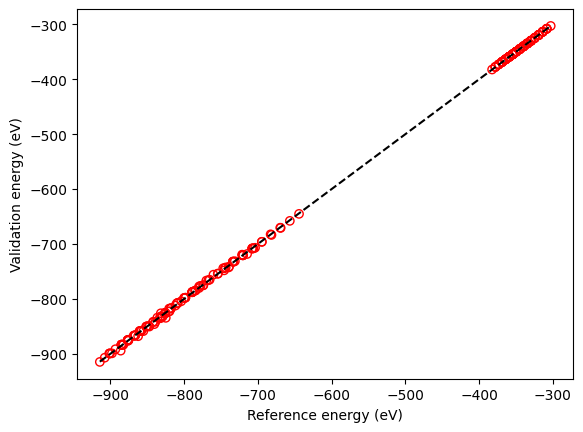

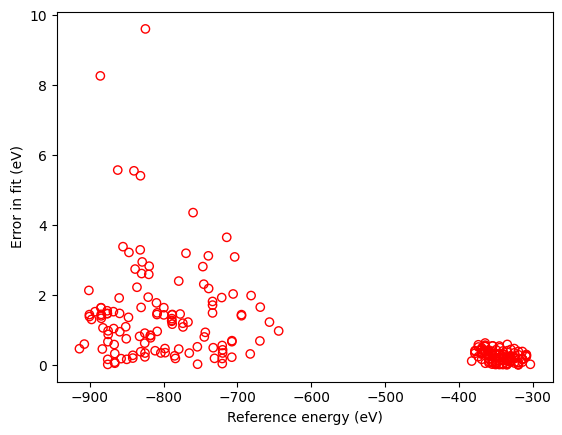

In [34]:
try:
    err=np.loadtxt("CCS_validate.dat")
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Validation energy (eV)')
    plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
    plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
    plt.show()
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Error in fit (eV)')
    plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
    plt.show()
except:
    pass

### Cleaning up

In [11]:
# import glob

# def rm(file):
#     try:
#         os.remove(file)
#     except OSError:
#         pass


# list=glob.glob("CALCULATED_DATA/*")
# for file in list:
#     rm(file)
# list=glob.glob("CCS_*")
# for file in list:
#     rm(file)
# list=glob.glob("UNC_*")
# for file in list:
#     rm(file)
# rm("structures.json")
# rm("file_list")
# rm("LJ.db")

### Convex hull

In [12]:
struct_no_Li = io.read('DFT.db@21')
struct_full_Li = io.read('DFT.db@10')

nrg_0 = struct_no_Li.get_potential_energy()
nrg_1 = struct_full_Li.get_potential_energy()

print(struct_no_Li.get_chemical_formula())
print(struct_full_Li.get_chemical_formula())

NameError: name 'io' is not defined

Text(0, 0.5, 'Energy')

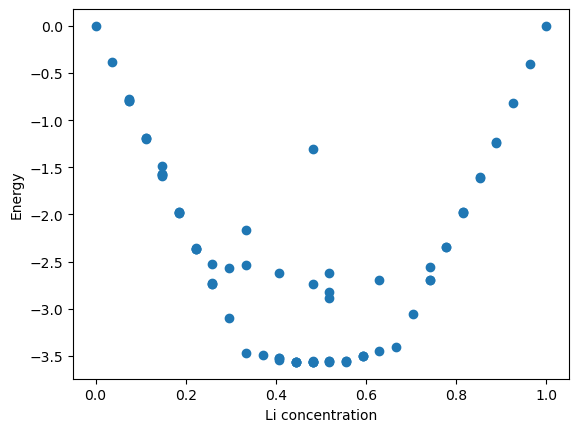

In [13]:
# CCS
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS 
from ase import io
import json
import ase.db as db
import matplotlib.pyplot as plt

with open("CCS_params.json", 'r') as f:
    CCS_params = json.load(f)

nrg_Li = CCS_params['One_body']['Li']
    
CCS_calc=CCS(CCS_params=CCS_params)
    
DFT_DB = db.connect('DFT.db')
    
xs = []
CCS_nrgs = []

i = 0

struct_no_Li_CCS = struct_no_Li.copy()
struct_full_Li_CCS = struct_full_Li.copy()

struct_no_Li_CCS.calc = CCS_calc
struct_full_Li_CCS.calc = CCS_calc

ECCS_no_Li = struct_no_Li_CCS.get_potential_energy()
ECCS_full_Li = struct_full_Li_CCS.get_potential_energy()

for row in DFT_DB.select():
    structure = row.toatoms()
    # print(structure.get_magnetic_moments())
    elems = structure.get_chemical_symbols()
    nr_Li = elems.count('Li')
    nr_Ni = elems.count('Ni')
    x = nr_Li/nr_Ni
    EDFT = structure.get_potential_energy()
    structure.calc = CCS_calc
    ECCS = structure.get_potential_energy() - (ECCS_no_Li) - (ECCS_full_Li-ECCS_no_Li)/27*nr_Li
    xs.append(x)
    CCS_nrgs.append(ECCS)
    i += 1

plt.scatter(xs, CCS_nrgs)
plt.xlabel("Li concentration")
plt.ylabel("Energy")

In [4]:
# CCS
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS 
from ase import io
import json
import ase.db as db

with open("CCS_params.json", 'r') as f:
    CCS_params = json.load(f)

nrg_Li = CCS_params['One_body']['Li']
    
CCS_calc=CCS(CCS_params=CCS_params)
    
DFT_DB = db.connect('DFT.db')
    
xs = []
DFT_nrgs = []

i = 0

for row in DFT_DB.select():
    structure = row.toatoms()
    # print(i)
    # print(dir(structure))
    # print(structure.get_magnetic_moment())
    elems = structure.get_chemical_symbols()
    nr_Li = elems.count('Li')
    nr_Ni = elems.count('Ni')
    x = nr_Li/nr_Ni
    print(i,x)
    EDFT = structure.get_potential_energy() - (nrg_0) - (nrg_1-nrg_0)/27*nr_Li
    xs.append(x)
    DFT_nrgs.append(EDFT)
    i += 1

plt.scatter(xs, DFT_nrgs)
plt.xlabel("Li concentration")
plt.ylabel("Energy")

0 0.48148148148148145
1 0.6296296296296297
2 0.7407407407407407
3 0.14814814814814814
4 0.25925925925925924
5 0.6666666666666666
6 0.7407407407407407
7 0.5925925925925926
8 0.5555555555555556
9 0.2962962962962963
10 1.0
11 0.37037037037037035
12 0.6296296296296297
13 0.14814814814814814
14 0.037037037037037035
15 0.8888888888888888
16 0.18518518518518517
17 0.8518518518518519
18 0.2222222222222222
19 0.7037037037037037
20 0.4444444444444444
21 0.0
22 0.07407407407407407
23 0.4074074074074074
24 0.18518518518518517
25 0.4444444444444444
26 0.25925925925925924
27 0.14814814814814814
28 0.8148148148148148
29 0.48148148148148145
30 0.3333333333333333
31 0.2962962962962963
32 0.5185185185185185
33 0.25925925925925924
34 0.8148148148148148
35 0.2222222222222222
36 0.07407407407407407
37 0.5925925925925926
38 0.5555555555555556
39 0.18518518518518517
40 0.4444444444444444
41 0.1111111111111111
42 0.14814814814814814
43 0.4074074074074074
44 0.48148148148148145
45 0.4074074074074074
46 0.51851

NameError: name 'plt' is not defined

In [6]:
from ase.optimize import BFGS
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
from tqdm import tqdm
from ase import io

struct = io.read('DFT.db@11')

struct = struct # * [2,2,2]

CCS_calc = CCS(CCS_params=CCS_params)

struct.rattle(0.05)
struct.calc = CCS_calc

opt = BFGS(struct, trajectory='opt.traj')
opt.run(fmax=0.001)

      Step     Time          Energy         fmax
BFGS:    0 10:48:52     -561.268213        0.1146
BFGS:    1 10:48:54     -561.269643        0.1122
BFGS:    2 10:48:56     -561.337006        0.0475
BFGS:    3 10:48:58     -561.340016        0.0643
BFGS:    4 10:49:01     -561.340464        0.0687
BFGS:    5 10:49:03     -561.341483        0.0736
BFGS:    6 10:49:05     -561.344638        0.0791
BFGS:    7 10:49:07     -561.350090        0.0722
BFGS:    8 10:49:09     -561.357177        0.0439
BFGS:    9 10:49:10     -561.362048        0.0239
BFGS:   10 10:49:12     -561.363869        0.0278
BFGS:   11 10:49:14     -561.364192        0.0303
BFGS:   12 10:49:15     -561.364356        0.0294
BFGS:   13 10:49:17     -561.365060        0.0261
BFGS:   14 10:49:19     -561.366362        0.0207
BFGS:   15 10:49:21     -561.369031        0.0135
BFGS:   16 10:49:23     -561.371671        0.0260
BFGS:   17 10:49:25     -561.373150        0.0294
BFGS:   18 10:49:28     -561.373529        0.0245
B

True

In [11]:
!ase gui opt.traj

In [1]:
# Read geometry optimized structure and run NVE Molecular dynamics 
import numpy as np
from ase import units
from ase.io import read, write
from ase.io.trajectory import Trajectory
from ase.md import MDLogger
from ase.md.verlet import VelocityVerlet
from ase.md.velocitydistribution import (MaxwellBoltzmannDistribution,
                                         Stationary, ZeroRotation)

dt = 0.5 * units.fs
steps = int(300)
MaxwellBoltzmannDistribution(struct, temperature_K=600)
dyn = VelocityVerlet(struct, timestep=dt)
interval = int(1)
dyn.attach(MDLogger(dyn, struct, 'output.log', mode="a"), interval=interval)
dyn.attach(Trajectory('output.traj', 'a', struct).write, interval=interval)
dyn.run(steps)

NameError: name 'struct' is not defined

In [2]:
!ase gui output.traj

usage: ase [-h] [--version] [-T]
           {help,info,test,gui,db,run,band-structure,build,dimensionality,eos,ulm,find,nebplot,nomad-upload,nomad-get,convert,reciprocal,completion,diff,exec}
           ...
ase: error: FileNotFoundError: [Errno 2] No such file or directory: 'output.traj'
To get a full traceback, use: ase -T gui ...


In [50]:
## Stresses not currently implemented in ccs_fit yet!

from ase.constraints import StrainFilter

sf = StrainFilter(struct)
opt = BFGS(sf)
opt.run(0.005)

      Step     Time          Energy         fmax
BFGS:    0 12:20:11    -4056.685755        0.0000


True

In [18]:
structs = io.read('output.traj@:')

print(len(structs))

602


In [15]:
for i in range(2):
    print(structs[(i+1)*50])
    

Atom('O', [1.5302522558471303, 0.6498901747917316, 8.350791516660168], momentum=[0.0014744864791352498, -0.0003861502676627821, -0.0013253298584316594], index=40)
Atom('O', [4.184446643135762, 2.4776447376680752, 3.7608334497495246], momentum=[-0.0030845779832983197, 0.0027338945258879575, 0.0021347184935242842], index=80)


Buckingham fit (not optimised) for element pair O-O;     V(r) = 0.00*exp(-0.58*r) -(0.00)/r^6.
Lennard Jones fit (not optimised) for element pair O-O;  V(r) = 4*-0.00*((2.25/r)^12 - (2.25/r)^6)
Morse fit (not optimised) for element pair O-O;          V(r) = -0.00*((1-np.exp(-0.73*(r-2.64)))^2 - 1)
Pedone fit (not optimised) for element pair O-O;         V(r) = -0.00*((1-np.exp(-0.93*(r-3.24)))^2 - 1) + 0.00/r^12


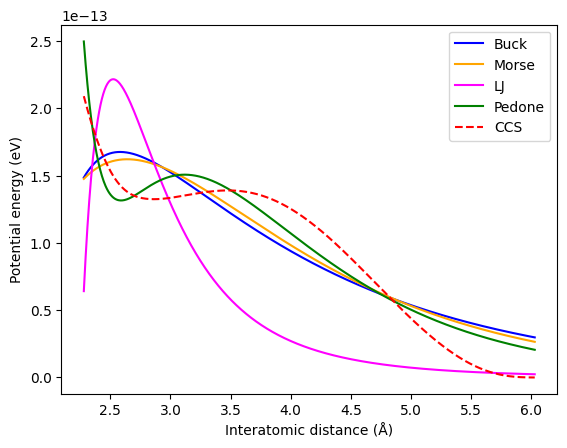

Buckingham fit (not optimised) for element pair Ta-Ta;     V(r) = 18.13*exp(-1.27*r) -(103.20)/r^6.
Lennard Jones fit (not optimised) for element pair Ta-Ta;  V(r) = 4*-0.36*((2.38/r)^12 - (2.38/r)^6)
Morse fit (not optimised) for element pair Ta-Ta;          V(r) = 3.68*((1-np.exp(-2.98*(r--6.83)))^2 - 1)
Pedone fit (not optimised) for element pair Ta-Ta;         V(r) = 3.68*((1-np.exp(-2.98*(r--6.83)))^2 - 1) + 36922.34/r^12


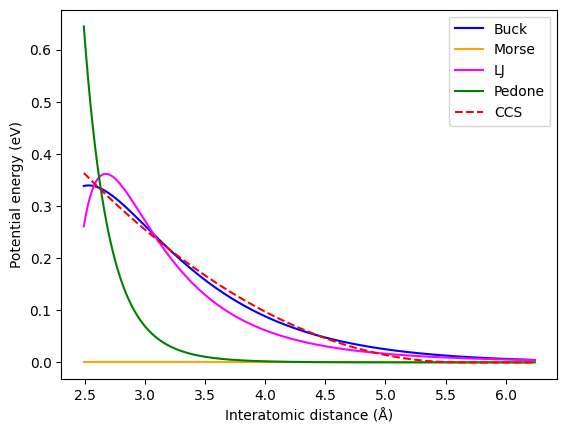

Buckingham fit (not optimised) for element pair Ta-Ni;     V(r) = 52.11*exp(-2.11*r) -(42.86)/r^6.
Lennard Jones fit (not optimised) for element pair Ta-Ni;  V(r) = 4*-0.13*((1.92/r)^12 - (1.92/r)^6)
Morse fit (not optimised) for element pair Ta-Ni;          V(r) = -0.12*((1-np.exp(-2.50*(r-2.24)))^2 - 1)
Pedone fit (not optimised) for element pair Ta-Ni;         V(r) = -0.00*((1-np.exp(-2.71*(r-3.50)))^2 - 1) + 23951.90/r^12


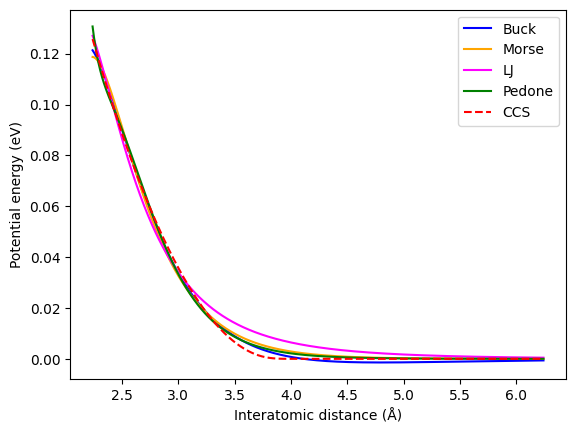

Buckingham fit (not optimised) for element pair Ta-Li;     V(r) = 38.93*exp(-2.14*r) -(25.51)/r^6.
Lennard Jones fit (not optimised) for element pair Ta-Li;  V(r) = 4*-5901.61*((0.31/r)^12 - (0.31/r)^6)
Morse fit (not optimised) for element pair Ta-Li;          V(r) = -0.05*((1-np.exp(-3.11*(r-2.64)))^2 - 1)
Pedone fit (not optimised) for element pair Ta-Li;         V(r) = -181.56*((1-np.exp(-3.23*(r-0.29)))^2 - 1) + -15111.72/r^12


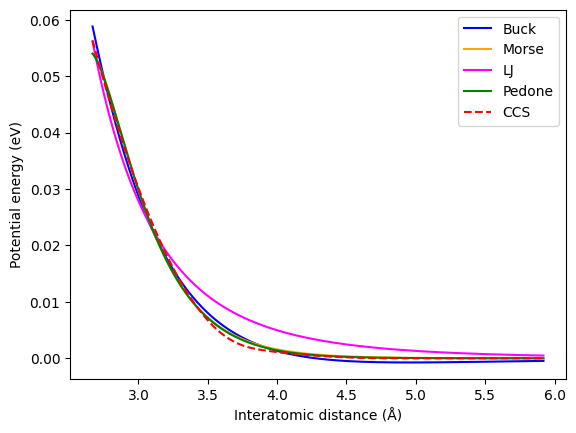

Buckingham fit (not optimised) for element pair Ni-Li;     V(r) = 2.75*exp(-1.14*r) -(9.46)/r^6.
Lennard Jones fit (not optimised) for element pair Ni-Li;  V(r) = 4*-0.14*((2.21/r)^12 - (2.21/r)^6)
Morse fit (not optimised) for element pair Ni-Li;          V(r) = -0.15*((1-np.exp(-1.18*(r-1.96)))^2 - 1)
Pedone fit (not optimised) for element pair Ni-Li;         V(r) = -0.11*((1-np.exp(-1.24*(r-2.36)))^2 - 1) + 735.86/r^12


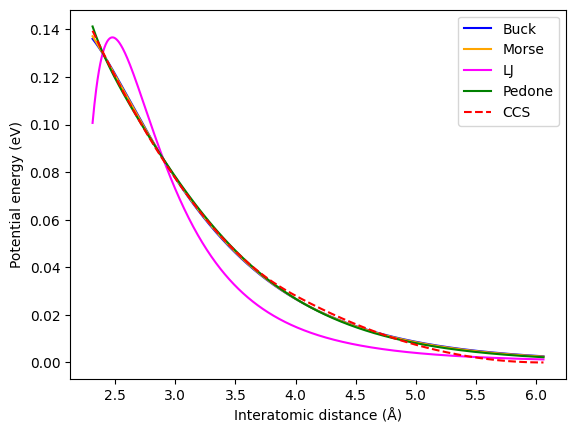

Buckingham fit (not optimised) for element pair Ni-Ni;     V(r) = 5.63*exp(-0.92*r) -(30.11)/r^6.
Lennard Jones fit (not optimised) for element pair Ni-Ni;  V(r) = 4*-0.57*((2.10/r)^12 - (2.10/r)^6)
Morse fit (not optimised) for element pair Ni-Ni;          V(r) = 2.84*((1-np.exp(-3.99*(r--6.06)))^2 - 1)
Pedone fit (not optimised) for element pair Ni-Ni;         V(r) = 2.84*((1-np.exp(-3.99*(r--6.06)))^2 - 1) + 9183.87/r^12


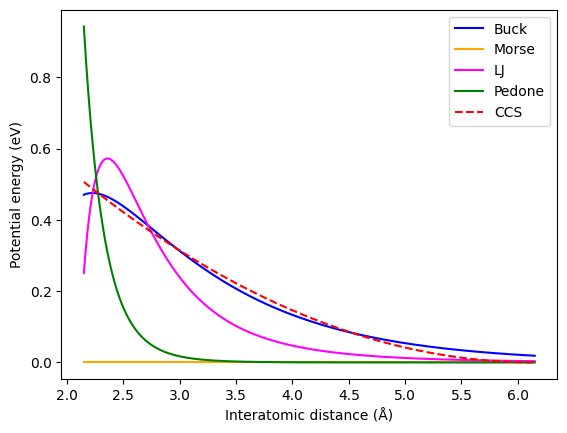

Buckingham fit (not optimised) for element pair Li-Li;     V(r) = 2.03*exp(-1.00*r) -(13.72)/r^6.
Lennard Jones fit (not optimised) for element pair Li-Li;  V(r) = 4*-0.13*((2.30/r)^12 - (2.30/r)^6)
Morse fit (not optimised) for element pair Li-Li;          V(r) = 2.99*((1-np.exp(-3.73*(r--6.47)))^2 - 1)
Pedone fit (not optimised) for element pair Li-Li;         V(r) = 2.99*((1-np.exp(-3.73*(r--6.47)))^2 - 1) + 7212.26/r^12


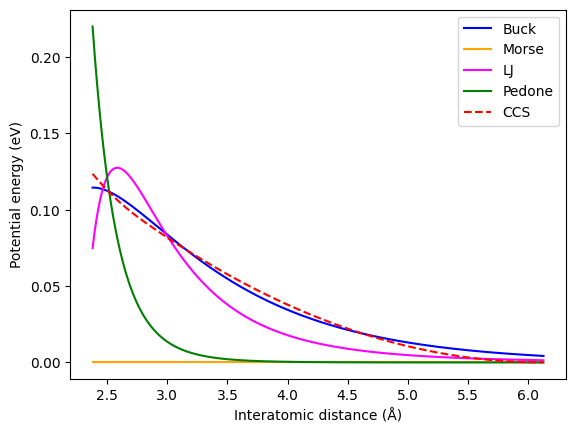

Buckingham fit (not optimised) for element pair Li-O;     V(r) = -0.10*exp(-0.64*r) -(-1.12)/r^6.
Lennard Jones fit (not optimised) for element pair Li-O;  V(r) = 4*0.02*((1.78/r)^12 - (1.78/r)^6)
Morse fit (not optimised) for element pair Li-O;          V(r) = 0.02*((1-np.exp(-0.88*(r-2.61)))^2 - 1)
Pedone fit (not optimised) for element pair Li-O;         V(r) = 0.02*((1-np.exp(-0.94*(r-2.67)))^2 - 1) + -10.93/r^12


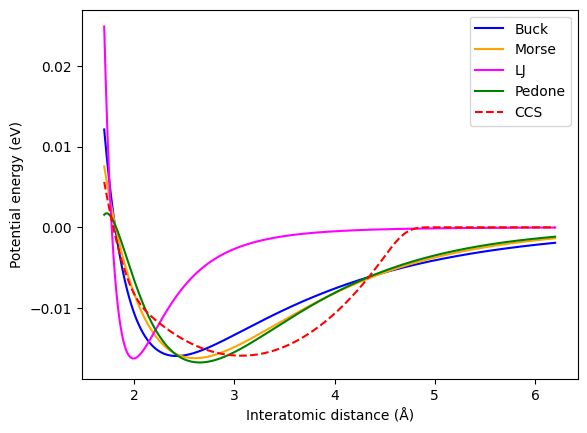

Buckingham fit (not optimised) for element pair Ni-O;     V(r) = 1.13*exp(-0.84*r) -(2.15)/r^6.
Lennard Jones fit (not optimised) for element pair Ni-O;  V(r) = 4*-0.25*((1.67/r)^12 - (1.67/r)^6)
Morse fit (not optimised) for element pair Ni-O;          V(r) = -0.19*((1-np.exp(-0.95*(r-1.68)))^2 - 1)
Pedone fit (not optimised) for element pair Ni-O;         V(r) = -0.16*((1-np.exp(-1.02*(r-1.99)))^2 - 1) + 38.12/r^12


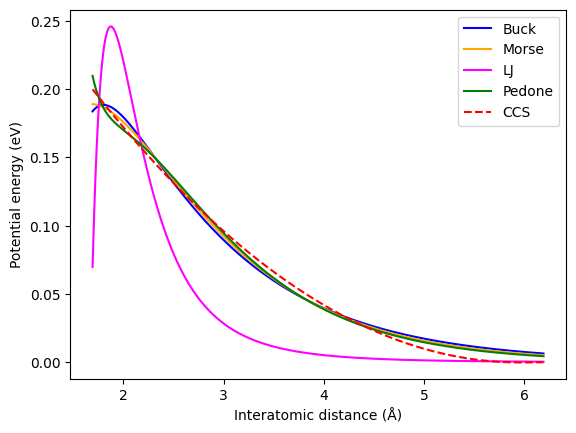

Buckingham fit (not optimised) for element pair O-Ta;     V(r) = -0.23*exp(-0.67*r) -(-2.00)/r^6.
Lennard Jones fit (not optimised) for element pair O-Ta;  V(r) = 4*0.04*((1.78/r)^12 - (1.78/r)^6)
Morse fit (not optimised) for element pair O-Ta;          V(r) = 0.04*((1-np.exp(-0.87*(r-2.49)))^2 - 1)
Pedone fit (not optimised) for element pair O-Ta;         V(r) = 0.04*((1-np.exp(-0.97*(r-2.62)))^2 - 1) + -40.39/r^12


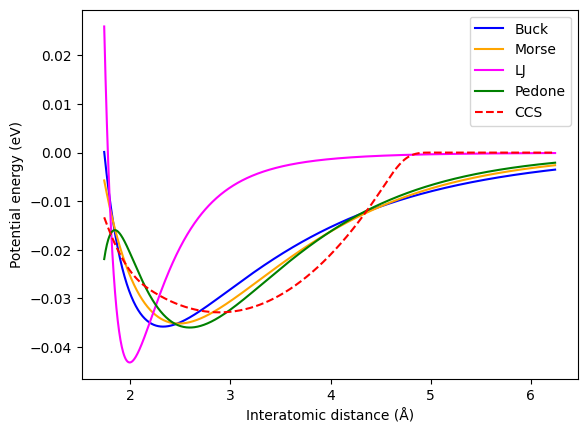

In [35]:
from ccs_fit.scripts.ccs_export_FF import write_FF
write_FF("CCS_params.json")